# Effect of repealing Child Tax Credit with Child Dividend

This identifies beneficiaries of the Child Tax Credit by modeling its repeal. Both repeal from current (2017) state and TCJA state are considered on a static basis. Change to after-tax income by decile and share of after-tax income held by top 10% are calculated.

*Data: CPS  |  Tax year: 2018  |  Type: Static  |  Author: Max Ghenis  |  Date run: 2018-02-20*

## Setup

### Imports

In [1]:
import taxcalc as tc
import pandas as pd
import numpy as np
import copy
from bokeh.io import show, output_notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# On Python 3.6 use "import urllib.request as url_lib".
import urllib as url_lib

In [2]:
tc.__version__

'0.17.0'

In [3]:
sns.set_style('white')
DPI = 75
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi']= DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [5]:
# Show one decimal in tables.
pd.set_option('precision', 2)

From https://stackoverflow.com/a/48999797/1840471.

**DOES NOT CURRENTLY WORK!**

Even though it did before. Could it be a Python3 thing, or new numpy or pandas?

In [192]:
def gini(x, w=None):
    # Array indexing requires reset indexes.
    x = pd.Series(x).reset_index(drop=True)
    if w is None:
        w = np.ones_like(x)
    w = pd.Series(w).reset_index(drop=True)
    n = x.size
    wxsum = sum(w * x)
    wsum = sum(w)
    sxw = np.argsort(x)
    sx = x[sxw] * w[sxw]
    sw = w[sxw]
    pxi = np.cumsum(sx) / wxsum
    pci = np.cumsum(sw) / wsum
    g = 0.0
    for i in np.arange(1, n):
        g = g + pxi.iloc[i] * pci.iloc[i - 1] - pci.iloc[i] * pxi.iloc[i - 1]
    return g

### Create reforms

CTC repeal involves eliminating the normal CTC as well as the new dependent credit for children.

A reform to return to 2017 CTC law is used to show how the distribution of CTC benefits changed with TCJA.

In [151]:
noctc_reform = {
    2018: {
        '_CTC_c': [0],
        '_DependentCredit_Child_c': [0]
    }
}

y2017_reform = {
    2018: {
        "_CTC_c": [1000.0],
        "_CTC_ps": [[75000.0, 110000.0, 55000.0, 75000.0, 75000.0]],
        "_ACTC_Income_thd": [3000.0],
        "_DependentCredit_Child_c": [0.0],
        "_DependentCredit_before_CTC": [0.0]
    }
}

### Specify `Calculator` objects for static analyses

In [8]:
recs = tc.Records.cps_constructor()

In [9]:
def static_baseline_calc(year):
    calc = tc.Calculator(records=recs, policy=tc.Policy())
    calc.advance_to_year(year)
    calc.calc_all()
    return calc

In [10]:
def weighted_sum(df, col):
    return (df[col] * df.s006).sum()

In [11]:
def add_weighted_quantiles(df, col):
    df.sort_values(by=col, inplace=True)
    col_pctile = col + '_percentile_exact'
    df[col_pctile] = 100 * df.s006.cumsum() / df.s006.sum()
    # "Null out" negatives using -1, since integer arrays can't be NaN.
    # TODO: Should these be null floats?
    df[col_pctile] = np.where(df[col] >= 0, df[col_pctile], 0)
    # Reduce top record, otherwise it's incorrectly rounded up.
    df[col_pctile] = np.where(df[col_pctile] >= 99.99999, 99.99999, 
                              df[col_pctile])
    df[col + '_percentile'] = np.ceil(df[col_pctile]).astype(int)
    df[col + '_2percentile'] = np.ceil(df[col_pctile] / 2).astype(int)
    df[col + '_ventile'] = np.ceil(df[col_pctile] / 5).astype(int)
    df[col + '_decile'] = np.ceil(df[col_pctile] / 10).astype(int)
    df[col + '_quintile'] = np.ceil(df[col_pctile] / 20).astype(int)
    df[col + '_quartile'] = np.ceil(df[col_pctile] / 25).astype(int)
    return df

In [152]:
def static_calc(ctc_treatment='keep',
                year=2018,
                cols=['s006', 'aftertax_income', 'expanded_income',
                      'n24', 'XTOT'],
                child_tax_units_only=True):
    """Creates static Calculator.

    Args:
        ctc_treatment: How the Child Tax Credit is treated. Options include:
            * 'keep': No change. Default.
            * 'repeal': End entirely.
            * 'y2017': Use 2017 law.
        year: Year to advance calculations to.
        cols: Columns to extract per Calculator record. 
            Defaults to ['s006', 'expanded_income', 'aftertax_income', 'nu18',
            'n24', 'XTOT'].
        child_tax_units_only: Limit tax units to those with n24 > 0. 
            Quantiles are calculated after this filtering. Defaults to true.
        
    Returns:
        DataFrame with `cols` and percentile, decile, and quintile of 
        after-tax income.
    """
    pol = tc.Policy()
    # Enact reform based on ctc_treatment.
    # Repeal CTC unless it's kept.
    if ctc_treatment == 'y2017':
        pol.implement_reform(y2017_reform)
    elif ctc_treatment != 'keep':
        pol.implement_reform(noctc_reform)
    # Calculate. This is needed to calculate the revenue-neutral UBI.
    calc = tc.Calculator(records=recs, policy=pol, verbose=False)
    calc.advance_to_year(year)
    calc.calc_all()
    # Create DataFrame and add identifiers.
    df = calc.dataframe(cols)
    if child_tax_units_only:
        df = df[df.n24 > 0]
    # Add percentiles.
    df = add_weighted_quantiles(df, 'expanded_income')
    df = add_weighted_quantiles(df, 'aftertax_income')
    # Add identifier.
    df['ctc_treatment'] = ctc_treatment
    # What's the column for the ID?
    df['id'] = df.index
    # Add weighted sums.
    df['expanded_income_b'] = df.expanded_income * df.s006 / 1e9
    df['aftertax_income_b'] = df.aftertax_income * df.s006 / 1e9
    df['n24_m'] = df.n24 * df.s006 / 1e6
    df['XTOT_m'] = df.XTOT * df.s006 / 1e6
    return df

In [153]:
scenarios = pd.concat([
    static_calc(ctc_treatment='keep'),
    static_calc(ctc_treatment='y2017'),
    static_calc(ctc_treatment='repeal')])

## Program cost and child allowance calculation

In [154]:
afti_summary = (
    scenarios.groupby('ctc_treatment')['aftertax_income_b', 'n24_m'].sum())
n24_m_total = afti_summary.iloc[0].n24_m
ctc_cost_b = (afti_summary.loc['keep'].aftertax_income_b -
              afti_summary.loc['repeal'].aftertax_income_b)
rev_neutral_ubi_per_n24 = 1000 * ctc_cost_b / n24_m_total
MAX_CTC = 2000
top_ubi_cost_b = n24_m_total * MAX_CTC / 1000 - ctc_cost_b
top_ubi_cost_b_pct = top_ubi_cost_b / ctc_cost_b

In [155]:
print('The CTC has an estimated total 2018 cost of ' + 
      '${:.1f}'.format(ctc_cost_b) + 'B.\n' +
      'This could cover a ${:,.0f}'.format(rev_neutral_ubi_per_n24) +
      ' child benefit for every CTC-eligible child.\n' +
      'Topping up to $2,000 per CTC-eligible child would cost ' +
      '${:.1f}'.format(top_ubi_cost_b) + 
      'B, a {:.1f}'.format(top_ubi_cost_b_pct * 100) + '% increase.')

The CTC has an estimated total 2018 cost of $123.6B.
This could cover a $1,454 child benefit for every CTC-eligible child.
Topping up to $2,000 per CTC-eligible child would cost $46.4B, a 37.5% increase.


Two comparison points:

1. PUF/TaxBrain estimates \$112.4B
2. [TPC's 2017 estimate](http://www.taxpolicycenter.org/publications/refundable-credits-earned-income-tax-credit-and-child-tax-credit/full) of \$52B plus [JCT's estimate](https://www.jct.gov/publications.html?func=startdown&id=5053) that TCJA's non-SSN reforms would cost \$68B starting in 2019, yields \$120B. The 2018 estimate of \$29B does not capture the refundable portions.

See https://github.com/open-source-economics/taxdata/issues/170.

Set revenue-neutral amount as a round number close to the quantified amount.

In [156]:
RN_UBI = 1450

## Preprocess

### Widen data

Create `tu`, a `DataFrame` with one row per tax unit.

In [157]:
tu.columns

Index([u'id', u'afti_keep', u'afti_repeal', u'n24', u's006', u'n24_m',
       u'XTOT_m', u'aftertax_income_percentile',
       u'aftertax_income_2percentile', u'aftertax_income_ventile',
       u'aftertax_income_decile', u'aftertax_income_quintile',
       u'aftertax_income_quartile', u'aftertax_income_percentile_repeal',
       u'aftertax_income_2percentile_repeal',
       u'aftertax_income_ventile_repeal', u'aftertax_income_decile_repeal',
       u'aftertax_income_quintile_repeal', u'aftertax_income_quartile_repeal',
       u'afti_ubi', u'afti_tubi', u'afti_keep_b', u'afti_repeal_b',
       u'afti_ubi_b', u'afti_tubi_b', u'repeal_afti_chg',
       u'repeal_afti_pctchg', u'ubi_afti_chg', u'ubi_afti_pctchg',
       u'tubi_afti_chg', u'tubi_afti_pctchg',
       u'keep_aftertax_income_per_person', u'ctc_per_n24'],
      dtype='object')

In [215]:
tu = scenarios.pivot_table(values='aftertax_income',
                           index='id', columns='ctc_treatment').reset_index()
tu.columns = ['id', 'afti_keep', 'afti_repeal', 'afti_y2017']

In [216]:
AFTI_QUANTILES = ['aftertax_income_percentile', 
                  'aftertax_income_2percentile', 'aftertax_income_ventile', 
                  'aftertax_income_decile', 'aftertax_income_quintile', 
                  'aftertax_income_quartile']

# Dimensions based on tax unit and baseline.
base_aftiq = (
    scenarios.loc[scenarios['ctc_treatment'] == 'keep',
                  np.append(['id', 'n24', 's006', 'n24_m', 'XTOT_m'], 
                            AFTI_QUANTILES)])
# Same for repeal scenario for showing who gets CTC.
repeal_aftiq = scenarios.loc[scenarios['ctc_treatment'] == 'repeal',
                             np.append(['id'], AFTI_QUANTILES)]
repeal_aftiq.columns = np.append(['id'], repeal_aftiq.columns[1:] + '_repeal').tolist()

In [217]:
tu = pd.merge(pd.merge(tu, base_aftiq, on='id'), repeal_aftiq, on='id')

### Add UBI scenario after-tax incomes

In [218]:
tu['afti_ubi'] = tu.afti_repeal + tu.n24 * RN_UBI
tu['afti_tubi'] = tu.afti_repeal + tu.n24 * MAX_CTC

In [219]:
for i in ['keep', 'repeal', 'y2017', 'ubi', 'tubi']:
    tu['afti_' + i + '_b'] = tu['afti_' + i] * tu.s006 / 1e9

In [220]:
def add_ratios(df):
    df['repeal_afti_chg'] = df.afti_repeal_b - df.afti_keep_b
    df['repeal_afti_pctchg'] = 100 * df.repeal_afti_chg / df.afti_keep_b
    df['ubi_afti_chg'] = df.afti_ubi_b - df.afti_keep_b
    df['ubi_afti_pctchg'] = 100 * df.ubi_afti_chg / df.afti_keep_b
    df['tubi_afti_chg'] = df.afti_tubi_b - df.afti_keep_b
    df['tubi_afti_pctchg'] = 100 * df.tubi_afti_chg / df.afti_keep_b
    df['keep_afti_pp'] = 1000 * df.afti_keep_b / df.XTOT_m
    df['ctc_per_n24'] = 1000 * (df.afti_keep_b - df.afti_repeal_b) / df.n24_m
    df['ctc_per_n24_2017'] = (
        1000 * (df.afti_y2017_b - df.afti_repeal_b) / df.n24_m)
    df['ctc_per_n24_2018'] = df.ctc_per_n24 - df.ctc_per_n24_2017

In [221]:
add_ratios(tu)

In [222]:
tu.sample(5)

,id,afti_keep,afti_repeal,afti_y2017,n24,s006,n24_m,XTOT_m,aftertax_income_percentile,aftertax_income_2percentile,...,repeal_afti_chg,repeal_afti_pctchg,ubi_afti_chg,ubi_afti_pctchg,tubi_afti_chg,tubi_afti_pctchg,keep_afti_pp,ctc_per_n24,ctc_per_n24_2017,ctc_per_n24_2018
38269,112385,16661.11,16515.71,16586.11,3.0,222.99,6.69e-04,8.92e-04,12,6,...,-3.24e-05,-0.87,9.38e-04,25.24,1.31e-03,35.14,4165.28,48.47,23.47,25.00
48052,141014,162693.33,157333.61,157333.61,4.0,16.29,6.52e-05,8.14e-05,92,46,...,-8.73e-05,-3.29,7.17e-06,0.27,4.30e-05,1.62,32538.67,1339.93,0.00,1339.93
113621,329457,14182.43,14182.43,14182.43,3.0,555.22,1.67e-03,5.55e-04,11,6,...,0.00e+00,0.00,2.42e-03,30.67,3.33e-03,42.31,14182.43,0.00,0.00,0.00
51610,151201,542938.26,542938.26,542938.26,2.0,39.82,7.96e-05,1.59e-04,100,50,...,0.00e+00,0.00,1.15e-04,0.53,1.59e-04,0.74,135734.57,0.00,0.00,0.00
112574,326281,96800.98,90800.98,93800.98,3.0,36.17,1.09e-04,1.81e-04,76,38,...,-2.17e-04,-6.20,-5.97e-05,-1.70,0.00e+00,0.00,19360.20,2000.00,1000.00,1000.00


Verify maximum CTC.

In [223]:
tu['ctc_per_n24'].max().round()

2000.0

In [224]:
tu['ctc_per_n24_2017'].max().round()

1000.0

### Quantile summaries

In [225]:
def quantile_summary(df, groupby):
    qs = df.groupby(groupby).sum()
    add_ratios(qs)
    # Exclude 0, the negative group.
    return qs.loc[1:]

In [226]:
quart = quantile_summary(tu, 'aftertax_income_quartile')
quint = quantile_summary(tu, 'aftertax_income_quintile')
dec = quantile_summary(tu, 'aftertax_income_decile')
vent = quantile_summary(tu, 'aftertax_income_ventile')
twopct = quantile_summary(tu, 'aftertax_income_2percentile')
pct = quantile_summary(tu, 'aftertax_income_percentile')

In [227]:
vent['percentile'] = vent.index * 5 - 2.5
twopct['percentile'] = twopct.index * 2 - 1

## Analysis

### Households and children reached

In [228]:
tax_units_reached = tu.loc[tu['repeal_afti_chg'] < 0, 's006'].sum()
share_of_tax_units_reached = tax_units_reached / tu['s006'].sum()

In [229]:
print('The CTC will reach {:.1f}'.format(tax_units_reached / 1e6) + 
      'M tax units in 2018.\n' +
      'This is {:.1f}'.format(share_of_tax_units_reached * 100) + 
      '% of all tax units with CTC-eligible children.')

The CTC will reach 42.3M tax units in 2018.
This is 87.4% of all tax units with CTC-eligible children.


### Gini

Runtime: ~1min.

In [232]:
ginis = pd.DataFrame({
    'keep': [gini(tu.afti_keep, tu.s006)],
    'repeal': [gini(tu.afti_repeal, tu.s006)],
    'ubi': [gini(tu.afti_ubi, tu.s006)],
    'tubi': [gini(tu.afti_tubi, tu.s006)]})

In [233]:
with pd.option_context('precision', 4):
    print(ginis)

     keep  repeal    tubi     ubi
0  0.4601  0.4694  0.4497  0.4549


### Distributional impact

### CTC per child by percentile

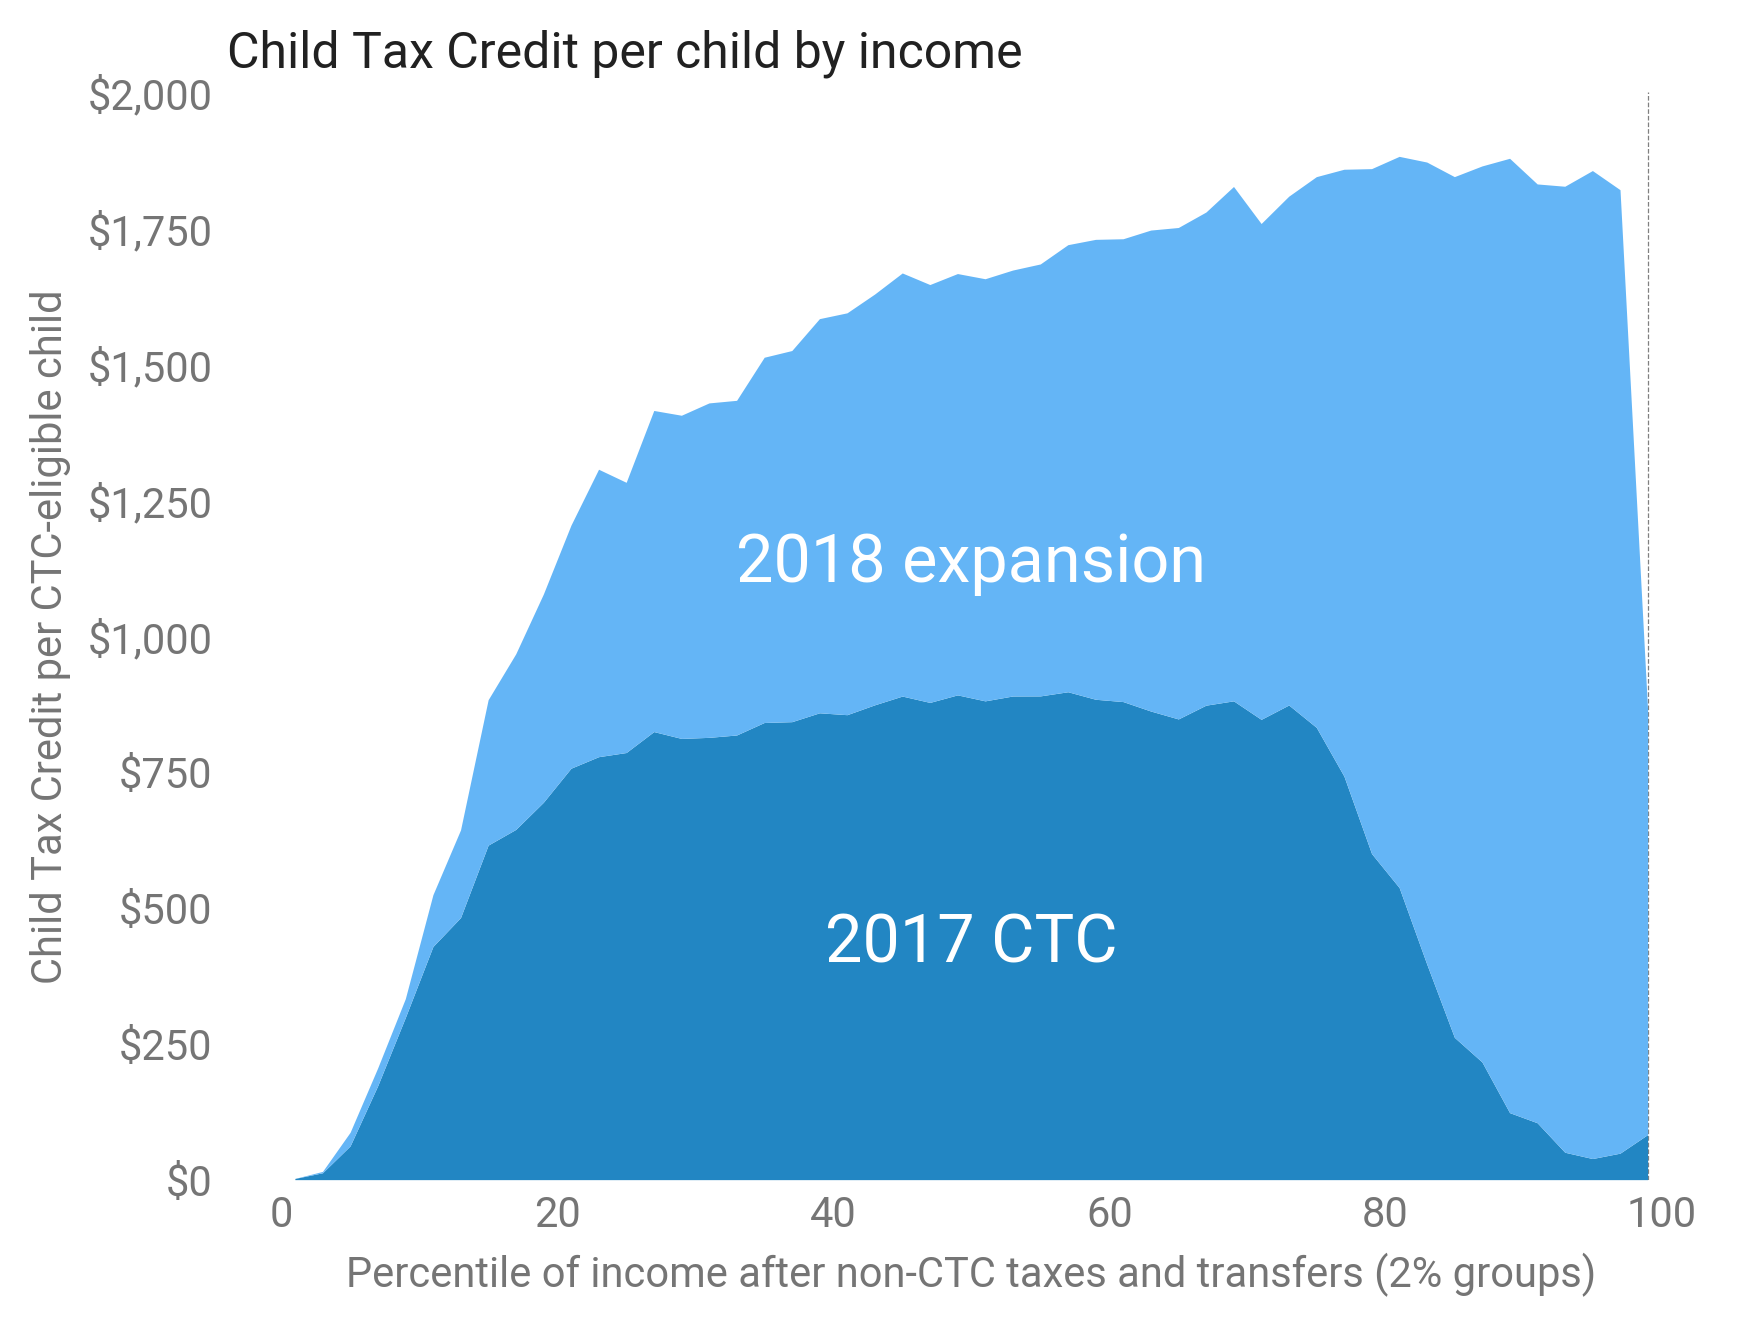

In [234]:
# Use colors from https://material.io/color/#!/?view.left=0&view.right=0&primary.color=64B5F6.
mpl.rcParams['figure.dpi']= 300
ax = twopct.plot(x='percentile', y=['ctc_per_n24_2017', 'ctc_per_n24_2018'],
    kind='area', color=['#2286c3', '#64b5f6'], linewidth=0)
ax.legend_.remove()
sns.despine(left=True, bottom=True)
ax.set(xlabel=
       'Percentile of income after non-CTC taxes and transfers (2% groups)',
       ylabel='Child Tax Credit per CTC-eligible child',
       ylim=(0, 2000))
plt.axvline(x=99, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
ax.text(50, 400, '2017 CTC', horizontalalignment='center', color='white', 
        size=16)
ax.text(50, 1100, '2018 expansion', horizontalalignment='center', 
        color='white', size=16)
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(int(x), ',')))
plt.title('Child Tax Credit per child by income', loc='left')
# plt.figure(dpi=1200)
plt.show()

### Distributional impact

In [235]:
UBI_LABEL = '$1,450 (revenue-neutral)'
UBI_LABEL2 = '\$1,450\n(revenue-neutral)'
UBI_LABEL_ML = '\$1,450\n(revenue-\nneutral)',
TUBI_LABEL = '$2,000 (current maximum)'
TUBI_LABEL2 = '\$2,000\n(current maximum)'
TUBI_LABEL_ML = '\$2,000\n(current\nmaximum)'

UBI_COLOR = '#757575'
TUBI_COLOR = '#388e3c'

UBI_LABELS = [UBI_LABEL, TUBI_LABEL]
UBI_COLORS = [UBI_COLOR, TUBI_COLOR]
UBI_COLS = ['ubi_afti_pctchg', 'tubi_afti_pctchg']

YLAB = 'Change to income after taxes and transfers'

#### Impact by quartile

In [236]:
quart[UBI_COLS]

,ubi_afti_pctchg,tubi_afti_pctchg
aftertax_income_quartile,,
1,7.87,13.06
2,-0.36,1.90
3,-0.76,0.66
4,-0.36,0.25


Overall impact on upper 75%.

In [237]:
upper_75p = quart.loc[2:].sum()
add_ratios(upper_75p)
with pd.option_context('precision', 2):
    print upper_75p[UBI_COLS]

ubi_afti_pctchg    -0.46
tubi_afti_pctchg    0.60
dtype: float64


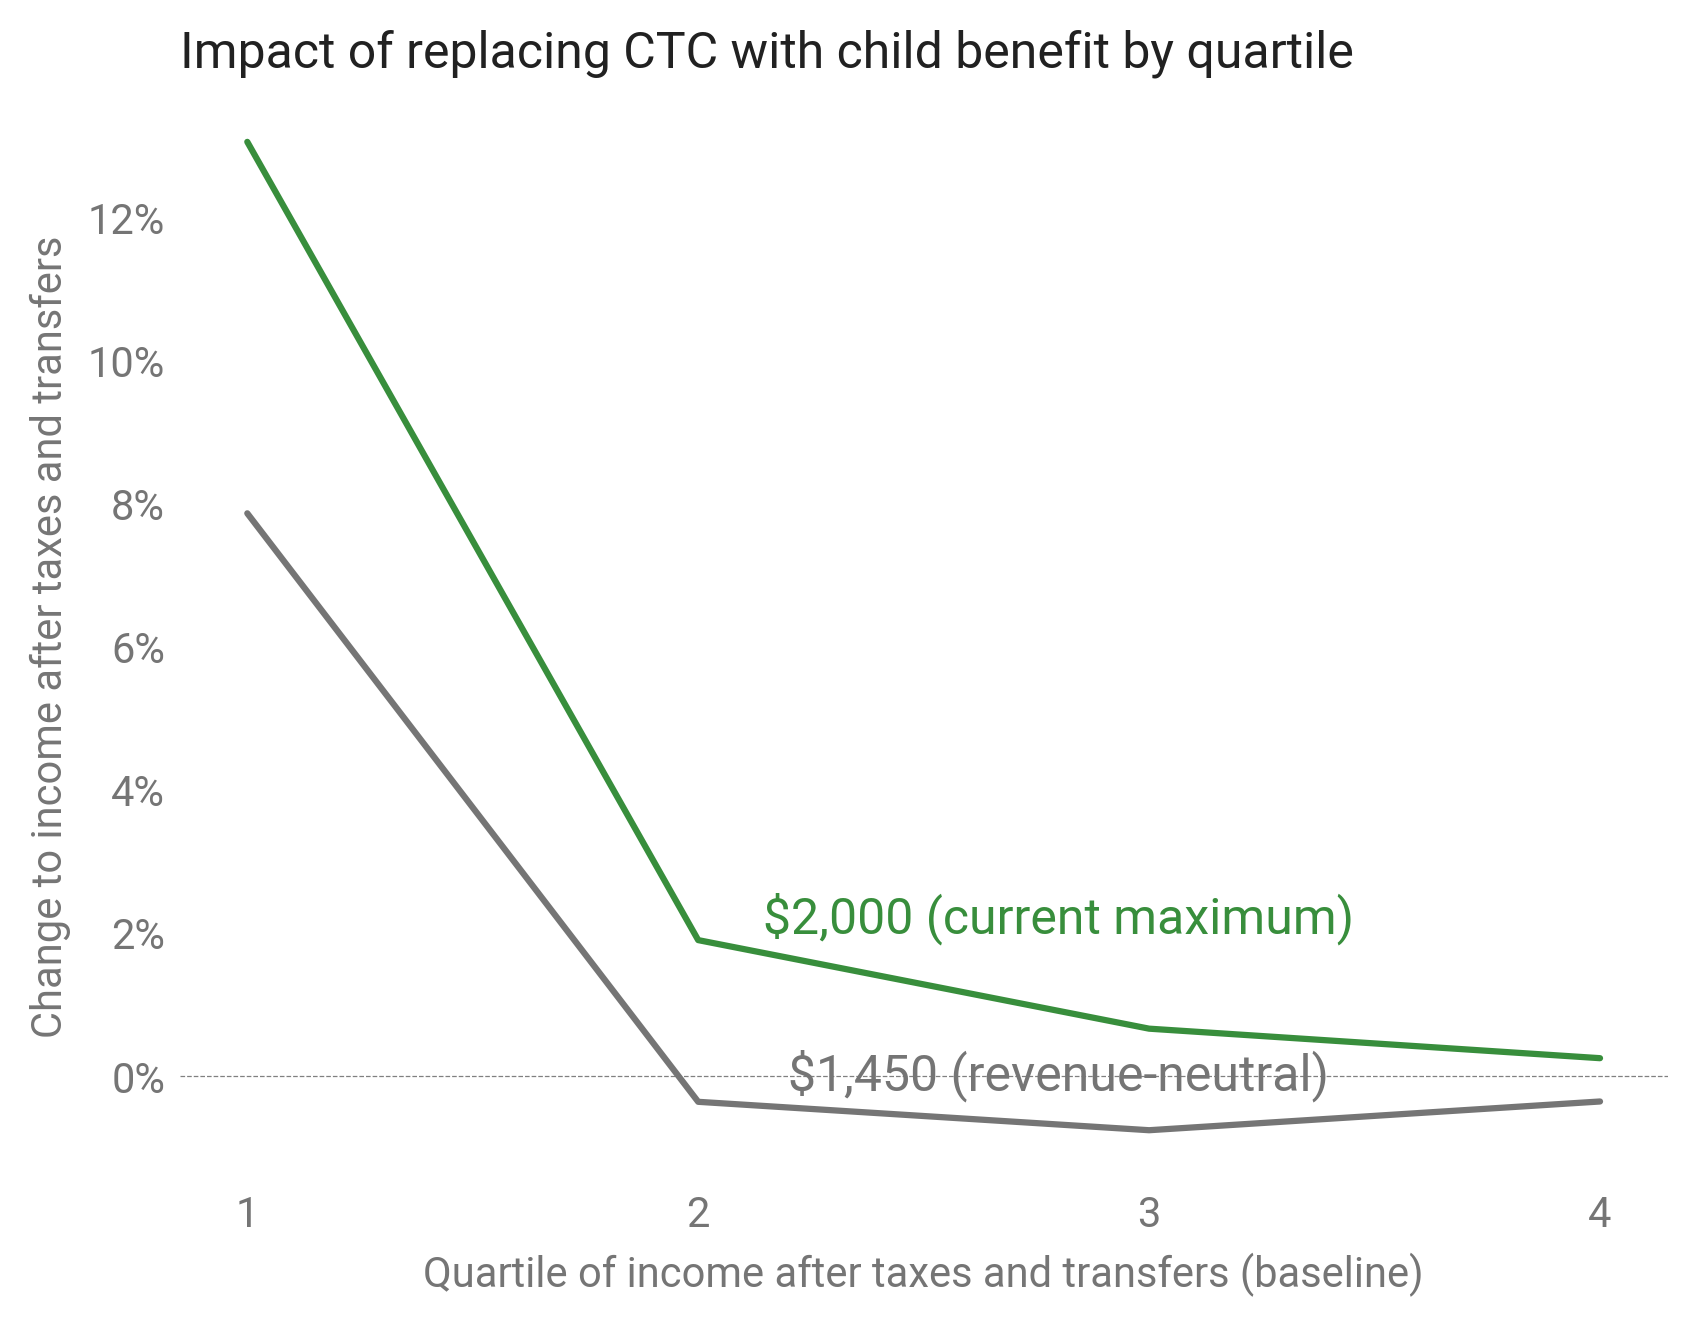

In [238]:
ax = quart.plot(y=UBI_COLS, color=UBI_COLORS)
ax.legend_.remove()
ax.text(2.8, 2, TUBI_LABEL, horizontalalignment='center', 
        color=TUBI_COLOR, size=12)
ax.text(2.8, -0.2, UBI_LABEL, horizontalalignment='center', 
        color=UBI_COLOR, size=12)
plt.axhline(y=0, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
sns.despine(left=True, bottom=True)
ax.set(xlabel='Quartile of income after taxes and transfers (baseline)',
       ylabel=YLAB,
       xticks=[1, 2, 3, 4])
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y / 100)))
plt.title('Impact of replacing CTC with child benefit by quartile', 
          loc='left')
plt.show()

#### Bottom quartile

In 5% increments.

In [239]:
vent.loc[:5, ['ubi_afti_pctchg', 'tubi_afti_pctchg', 
              'keep_aftertax_income_per_person', 's006']]

/usr/local/google/home/mghenis/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


,ubi_afti_pctchg,tubi_afti_pctchg,keep_aftertax_income_per_person,s006
aftertax_income_ventile,,,,
1,145.64,201.62,NaN,2.40e+06
2,20.86,30.33,NaN,2.42e+06
3,6.81,11.44,NaN,2.42e+06
4,2.77,6.12,NaN,2.42e+06
5,0.99,3.90,NaN,2.42e+06


\$1057 per person per year is roughly $2.90 per day. 2.4M households in each ventile.

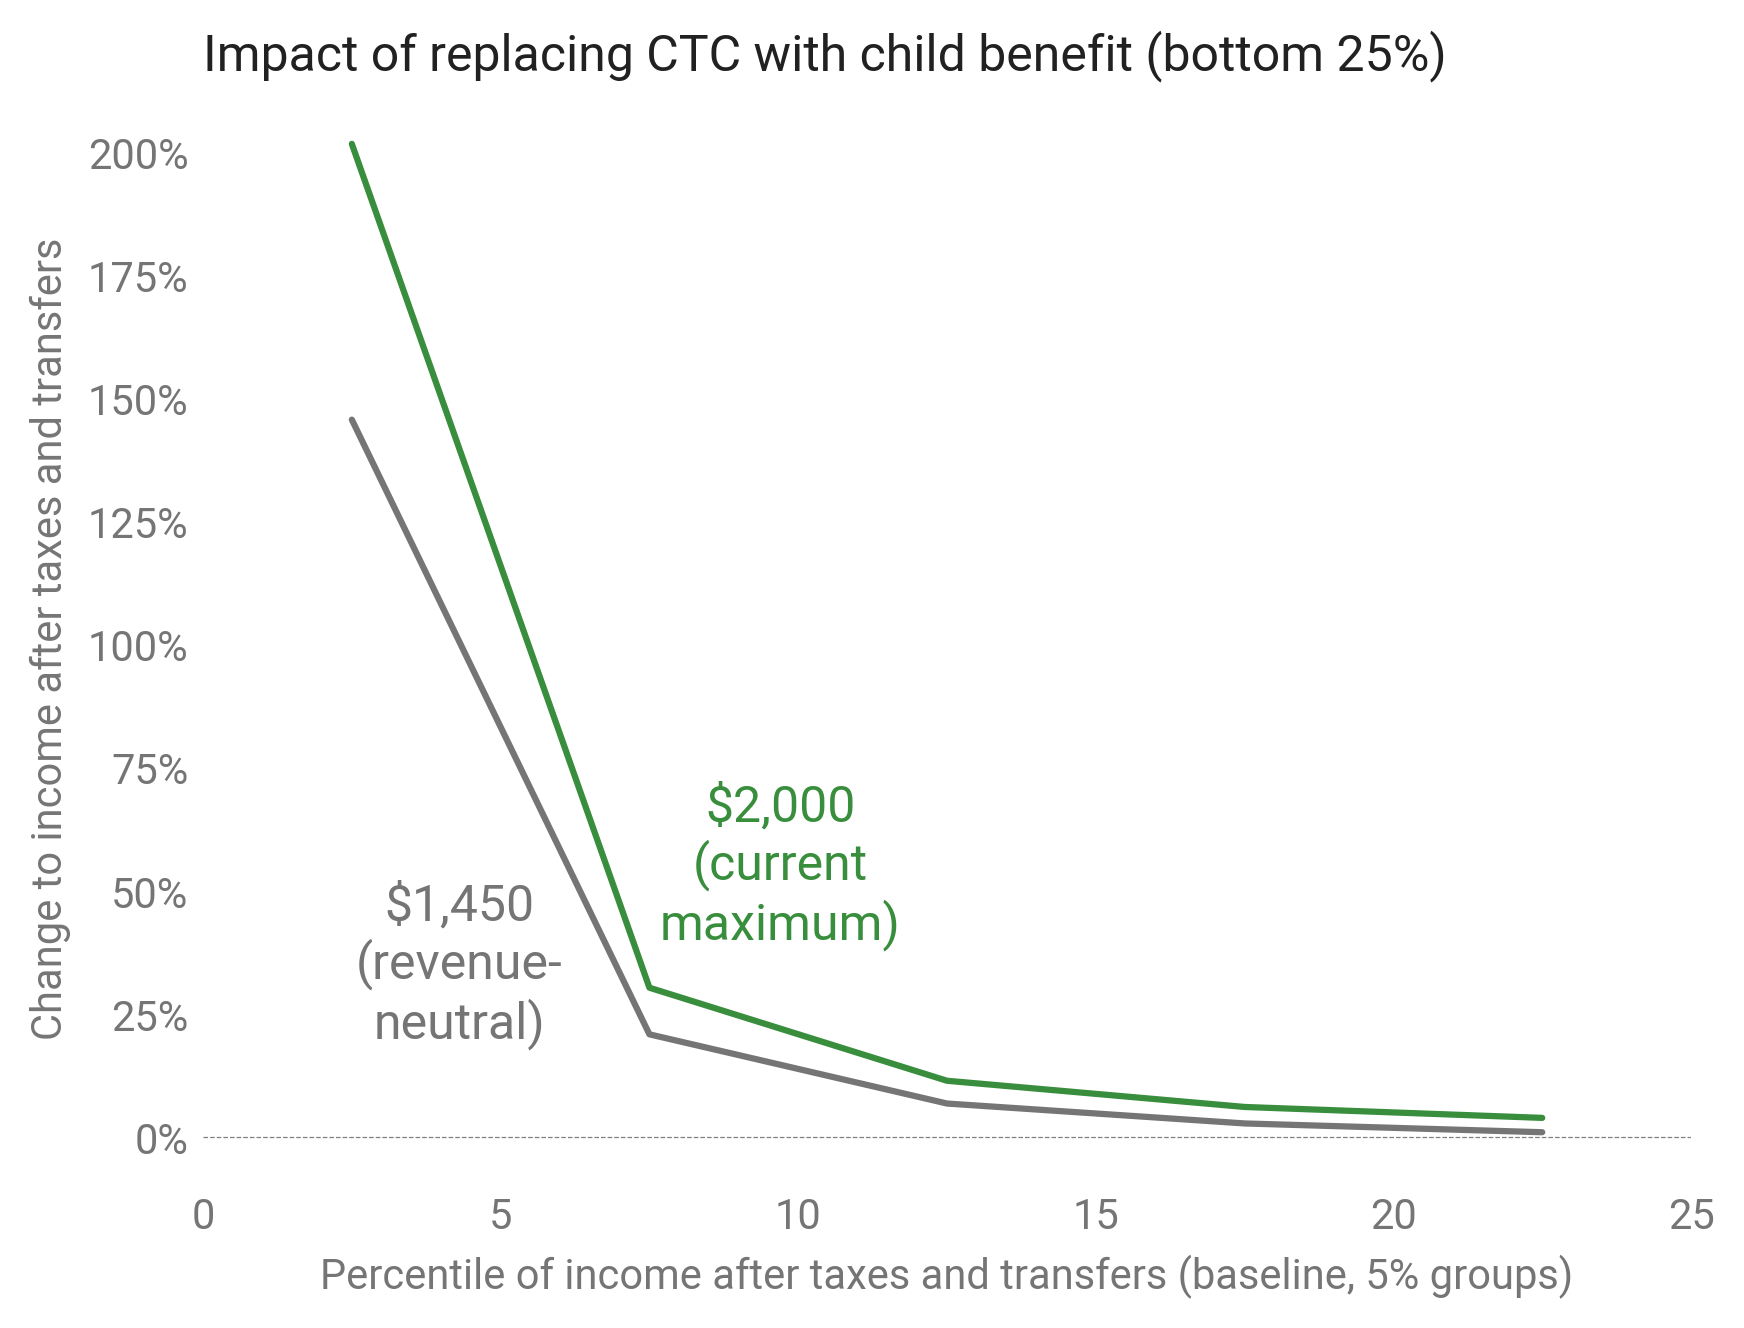

In [245]:
ax = vent[:5].plot(x='percentile', y=UBI_COLS, color=UBI_COLORS)
ax.legend_.remove()
ax.text(9.7, 40, '\$2,000\n(current\nmaximum)', horizontalalignment='center', 
        color=TUBI_COLOR, size=12)
ax.text(4.3, 20, '\$1,450\n(revenue-\nneutral)', horizontalalignment='center',
        multialignment='center', color=UBI_COLOR, size=12)
plt.axhline(y=0, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
sns.despine(left=True, bottom=True)
ax.set(xlabel=
       'Percentile of income after taxes and transfers (baseline, 5% groups)',
       ylabel=YLAB,
       xlim=[0, 25])
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y / 100))) 
plt.title('Impact of replacing CTC with child benefit (bottom 25%)', 
          loc='left')
plt.show()

#### Impact on upper 75%.

In [251]:
twopct.loc[48:, UBI_COLS]

,ubi_afti_pctchg,tubi_afti_pctchg
aftertax_income_2percentile,,
48,-0.39,0.14
49,-0.29,0.14
50,0.23,0.45


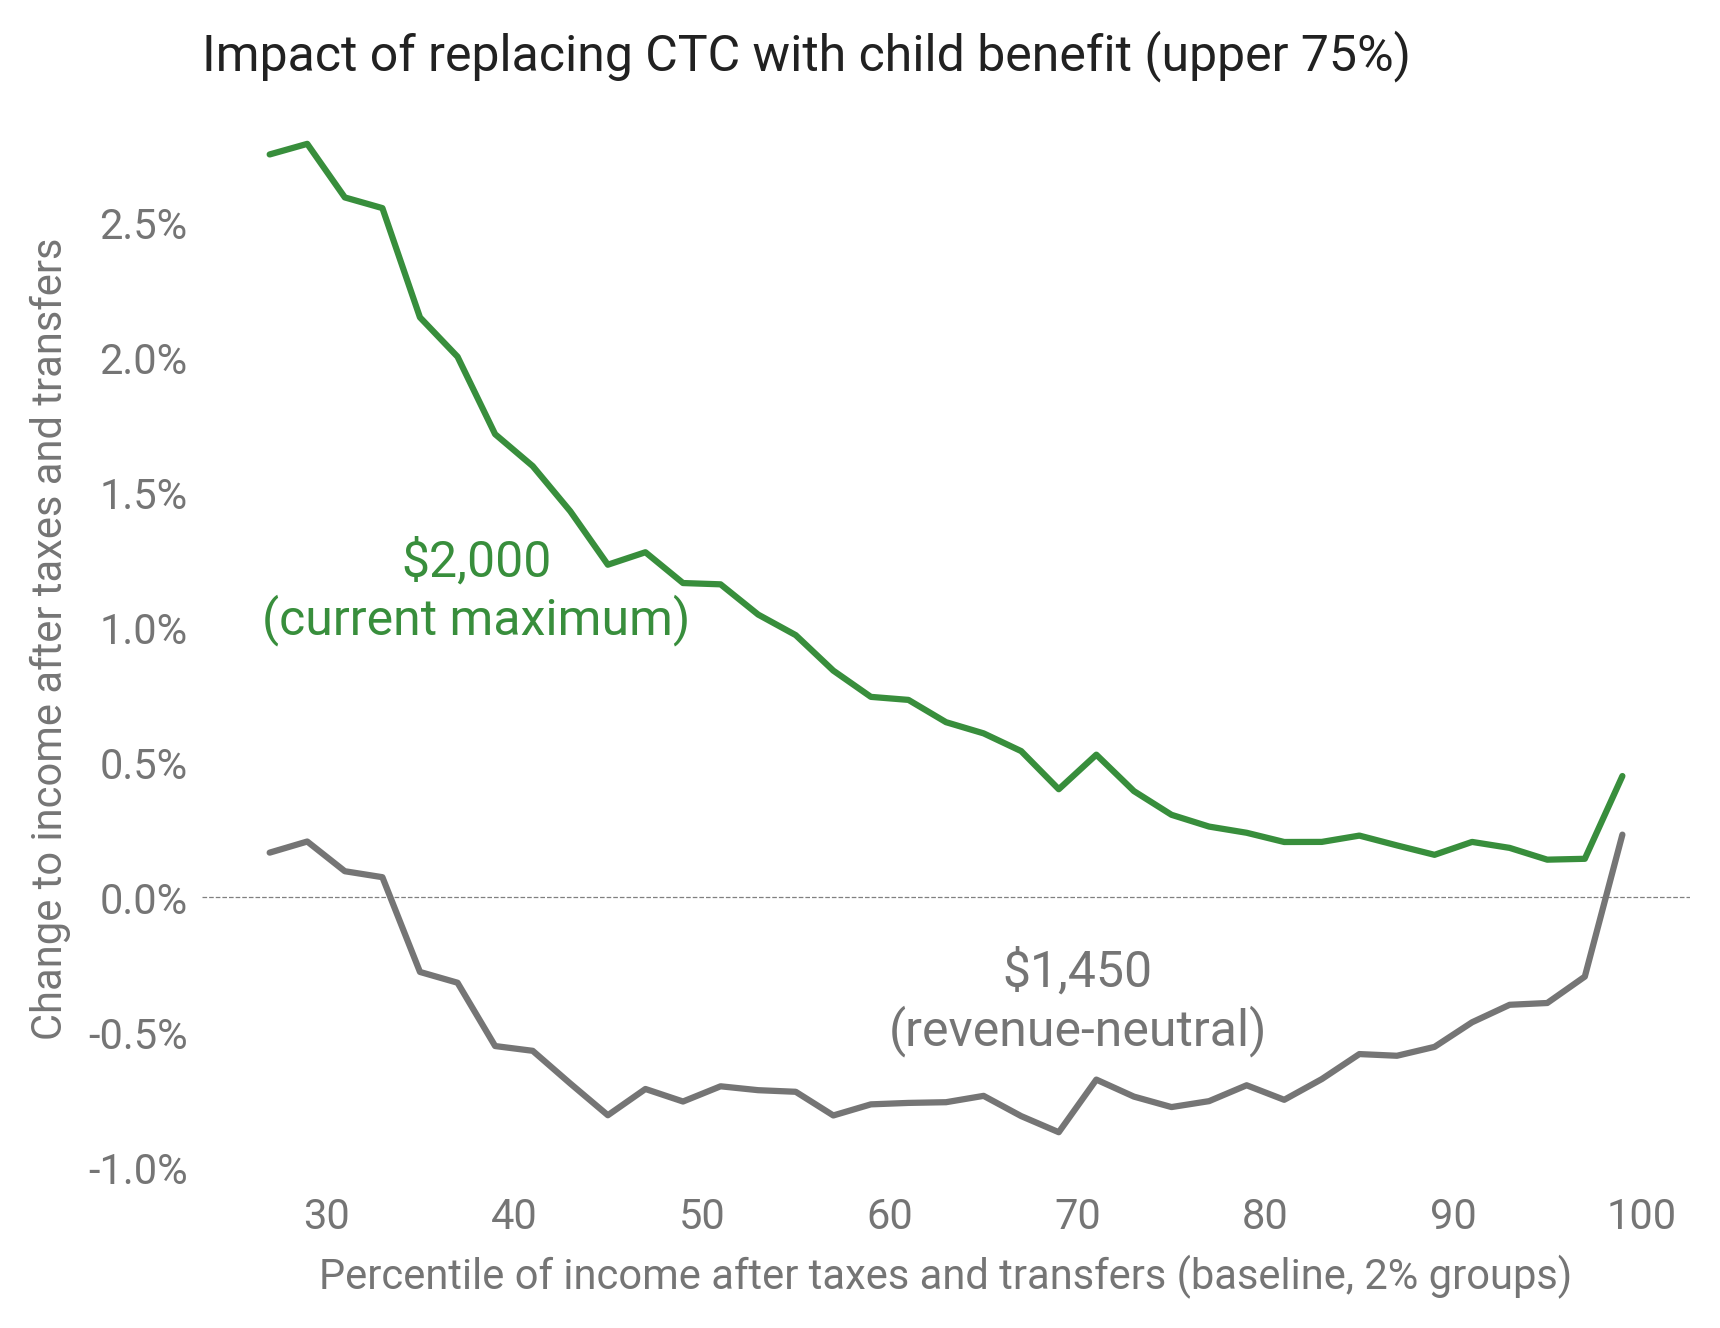

In [250]:
ax = twopct[13:].plot(x='percentile', y=UBI_COLS, color=UBI_COLORS)
# ax.legend(UBI_LABELS)  # If new data.
ax.legend_.remove()
ax.text(38, 0.97, TUBI_LABEL2, horizontalalignment='center', 
        color=TUBI_COLOR, size=12)
ax.text(70, -0.55, UBI_LABEL2, horizontalalignment='center',
        color=UBI_COLOR, size=12)
plt.axhline(y=0, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
sns.despine(left=True, bottom=True)
ax.set(xlabel=
       'Percentile of income after taxes and transfers (baseline, 2% groups)',
       ylabel=YLAB)
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.1%}'.format(y / 100))) 
plt.title('Impact of replacing CTC with child benefit (upper 75%)',
          loc='left')
plt.show()

Top 1% does better off. 2nd percentile is basically flat.

In [ ]:
pct.loc[98:, ['ubi_afti_pctchg', 'tubi_afti_pctchg']]

In [ ]:
twopct.loc[50, ['ubi_afti_pctchg', 'tubi_afti_pctchg']]

In [ ]:
dec['ubi_afti_pctchg'].plot()
plt.show()

In [ ]:
(-dec['repeal_afti_pctchg']).plot()
plt.show()

In [ ]:
pct['ubi_afti_pctchg'].plot()
plt.show()

In [ ]:
pct['ubi_afti_pctchg']

In [ ]:
pct['ubi_afti_chg_per_nu18'].plot()
plt.show()

In [ ]:
dec['ctc_per_nu18'].plot()
plt.show()

In [ ]:
pct_e['ctc_per_n24'].plot()
plt.show()

In [ ]:
pct_e['ctc_per_nu18'].plot()
plt.show()

In [ ]:
pct['ctc_per_nu18']

## Appendix

Tax units with greatest change to after-tax income from the UBI model.

In [ ]:
scenario18[(scenario18['rev_neutral_ubi_aftertax_income_b'] >= 0) &
           (scenario18['keep_aftertax_income_b'] >= 0) &
           (scenario18['ubi_afti_chg'] < np.inf)].sort_values(
    'ubi_afti_chg').tail()

### Differences between `nu18` and `n24`

What explains the difference by decile?

In [ ]:
keep_cur = scenarios[(~scenarios['use_2017_law']) & 
                     (scenarios['ctc_treatment'] == 'keep')]
print ('Total children under 18: ' +
       '{:0.1f}M'.format((keep_cur['nu18_m'].sum())))
print ('Total children eligible for CTC: ' +
       '{:0.1f}M'.format((keep_cur['n24_m'].sum())))

How many households have nu18 > n24? n24 > nu18?

In [ ]:
keep_cur.pivot_table(index='n24', columns='nu18', values='s006', aggfunc=sum)

In [ ]:
keep_cur[keep_cur['nu18'] > keep_cur['n24']]['s006'].sum() / 1e6

In [ ]:
keep_cur[keep_cur['n24'] > keep_cur['nu18']]['s006'].sum() / 1e6

#### `n18 / n24` by percentile

In [ ]:
pct_e_cur = keep_cur.groupby('expanded_income_percentile').sum()
pct_e_cur['n24_per_nu18'] = pct_e_cur['n24_m'] / pct_e_cur['nu18_m']

In [ ]:
pct_e_cur['n24_per_nu18'].head(10)

In [ ]:
dec_e_cur = keep_cur.groupby('expanded_income_decile').sum()
dec_e_cur['n24_per_nu18'] = dec_e_cur['n24_m'] / dec_e_cur['nu18_m']

In [ ]:
dec_e_cur[['n24_m', 'nu18_m', 'n24_per_nu18']]

In [ ]:
f, ax = plt.subplots()
(twopct['nu18_m'] / pct['nu18_m'].sum()).plot(label='Children under 18')
(twopct['n24_m'] / pct['n24_m'].sum()).plot(label='CTC-eligible children')
sns.despine(left=True, bottom=True)
plt.legend()
ax.set(xlabel='Percentile of income after taxes and transfers',
       ylabel='Share of children under 18')
plt.axhline(y=0.01, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
plt.title('Share of children by after-tax income percentile', loc='left')
plt.show()

Ratio between the two.

In [ ]:
f, ax = plt.subplots()

pct_e_cur['n24_per_nu18'].plot()

sns.despine(left=True, bottom=True)

ax.set(xlabel='Expanded Income Percentile',
       ylabel='CTC-eligible children per child under 18')

plt.title('CTC-eligible children per child under 18, by income percentile',
          loc='left')

plt.axhline(y=1, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)

plt.show()

## Utility functions

In [ ]:
# Function that takes a set of dimensions and metrics, and 
# creates a summary table where metrics are properly weighted.

### Extra charts

#### CTC per child by ventile

Percentile shows the drop at top two percentiles more clearly.

In [ ]:
# Use colors from https://material.io/color/#!/?view.left=0&view.right=0&primary.color=64B5F6.
ax = vent.plot(x='percentile', y=['ctc_per_nu18_2017', 'ctc_per_nu18_2018'],
    kind='area', color=['#2286c3', '#64b5f6'], linewidth=0)
ax.legend_.remove()
sns.despine(left=True, bottom=True)
ax.set(xlabel='Percentile of income after non-CTC taxes and transfers',
       ylabel='Child Tax Credit per child under 18',
       ylim=(0, 2000))
plt.axvline(x=100, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
ax.text(50, 400, '2017 CTC', horizontalalignment='center', color='white', 
        size=16)
ax.text(50, 1100, '2018 expansion', horizontalalignment='center', 
        color='white', size=16)
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.title('Child Tax Credit per child by income', loc='left')
plt.show()

#### Top 70% by decile.

Moved to quartiles/ventiles/percentiles.

In [ ]:
ax = dec[4:].plot(y=['ubi_afti_pctchg', 'tubi_afti_pctchg'])
ax.legend(['$1,445 (revenue-neutral)', '$2,000 (current maximum)'])
plt.axhline(y=0, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
sns.despine(left=True, bottom=True)
ax.set(xlabel='Decile of income after taxes and transfers (baseline)',
       ylabel='% change to income after taxes and transfers')
plt.title('Distributional impact of replacing CTC with child dividend', 
          loc='left')
plt.show()

#### Upper 75% in ventiles

In [ ]:
ax = vent[6:].plot(y=['ubi_afti_pctchg', 'tubi_afti_pctchg'])
ax.legend(['$1,445 (revenue-neutral)', '$2,000 (current maximum)'])
plt.axhline(y=0, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
sns.despine(left=True, bottom=True)
ax.set(xlabel='Ventile of income after taxes and transfers (baseline)',
       ylabel='% change to income after taxes and transfers') #,
#        yticks=[0, 5, 10, 15, 20, 25])
plt.title('Impact of replacing CTC with child dividend (upper 75%)',
          loc='left')
plt.show()

Overall deciles (replaced with quartiles).

In [ ]:
ax = dec.plot(y=['ubi_afti_pctchg', 'tubi_afti_pctchg'])
ax.legend(['$1,445 (revenue-neutral)', '$2,000 (current maximum)'])
plt.axhline(y=0, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
sns.despine(left=True, bottom=True)
ax.set(xlabel='Decile of income after taxes and transfers (baseline)',
       ylabel='% change to income after taxes and transfers') #,
#        yticks=[0, 5, 10, 15, 20, 25])
plt.title('Distributional impact of replacing CTC with child dividend',
          loc='left')
plt.show()

#### Bottom decile by percentile.

Too big an effect for bottom 1-2% to report.

In [ ]:
pct.loc[:30, 'ubi_afti_pctchg']

In [ ]:
ax = pct[:30].plot(y=['ubi_afti_pctchg', 'tubi_afti_pctchg'])
ax.legend(['$1,445 (revenue-neutral)', '$2,000 (current maximum)'])
sns.despine(left=True, bottom=True)
ax.set(xlabel='Percentile of income after taxes and transfers (baseline)',
       ylabel='% change to income after taxes and transfers',
       ylim=0)
plt.title('Impact on bottom decile of replacing CTC with revenue-neutral ' +
          'child dividend', loc='left')
plt.show()